#### For this problem set I worked with Eugene Leypunskiy

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import string
from collections import Counter, OrderedDict
import nltk
from nltk.corpus import stopwords
import re
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.clustering import DistributedLDAModel

### Part 2(a): Make vocabulary

In [81]:
stack_file = open('/project/cmsc25025/stackexchange/20161215StatsPostsMerged.csv','r').readlines()

spark = SparkSession.builder.master('local[56]')\
                            .appName('stack_exchange')\
                            .config("spark.driver.maxResultSize", "20g")\
                            .config("spark.driver.memory", "20g")\
                            .config("spark.executor.memory", "20g")\
                            .getOrCreate()


stack_data = spark.sparkContext.parallelize(stack_file[1:])

### Steps to make vocabulary
1. First we split the data by comma to get the document ID
2. The first entry after splitting comma is always the doc ID
3. Substitute a blank space for anything that's not a space or lowercase alphabets
4. Split the string up into words
5. Make them unicodes
6. Return the document ID and words in list
7. Count number of words throughout the corpus
8. Get rid of any words that have less than or equal to 3 characters
9. Get rid of stopwords
10. Remove words that have less than or equal to 35 counts


In [3]:
def clean_string(s):
    sForID = s.split(',') # Splitting data to get document ID
    docID = sForID[0] # first index after split is the docID
    s = re.sub('[^a-z\ \']+', " ", s.lower().strip()) # substitute everything except letters + space with white space
    s = s.split()
    s = [i.decode('utf-8') for i in s]                # Make Unicode
    return docID, s                          # Return doc ID + list of words

In [4]:
vocabulary = stack_data.map(lambda x: clean_string(x))\
                       .map(lambda x: Counter(x[1]))\
                       .reduce(lambda a,b: a + b)


In [5]:
vocabulary = Counter({k:v for k,v in vocabulary.items() if len(k) > 3}).most_common()
print len(vocabulary)
vocabulary= dict(vocabulary)
stopWords = nltk.corpus.stopwords.words('english')

for i in stopWords:
    try:
        vocabulary.pop(i.decode('utf-8'))
    except KeyError:
        continue
print len(vocabulary)
vocabulary = dict(vocabulary)
vocabulary = Counter({k:v for k,v in vocabulary.items() if v > 35 }).most_common()
vocabulary = OrderedDict(vocabulary)

100928
100847


### Part 2(b): Topic modelling with k=30

In [6]:
# Parser for mapping each entry to a sequence of word-id/count pairs

def map_wordid_count(x, masterVocab):
    docId = x[0]
    counterObj = x[1]
    dumTupleList = []
    keys = []
    values = []
    for i, word in enumerate(masterVocab):
        if word in counterObj:
            keys.append(i)
            values.append(counterObj[word])

    return (docId, Vectors.sparse(len(masterVocab), keys, values))
            
        
        
    

In [7]:
# Split Data into train and test
stack_dataTrain, stack_dataTest = stack_data.randomSplit([9, 1])

In [8]:
# Map each document to (docID, [word-ID, cnt]) tuples
parsedDataTrain = stack_dataTrain.map(lambda x: (clean_string(x)))\
                                 .map(lambda x: (int("{:.0f}".format(float(x[0]))), Counter(x[1])))\
                                 .map(lambda x: map_wordid_count(x, vocabulary))\
                                 .map(list)

In [19]:
# Train LDA Model
parsedDF = parsedDataTrain.toDF(["id","features"])
lda = LDA(k=30, maxIter=50)
model = lda.fit(parsedDF)


In [20]:
# Get list of words and cnts from vocabulary
masterWords = []
masterCnts = []
for i in vocabulary:
    masterWords.append(i), 
    masterCnts.append(vocabulary[i])

In [21]:
# For all topics, get term indices and term weights 
termIndices = model.describeTopics()\
                   .select("termIndices").rdd.map(list).map(lambda x:x[0]).collect()
termWeights = model.describeTopics()\
                   .select("termWeights").rdd.map(list).map(lambda x:x[0]).collect()

In [22]:
# Display topics with top 10 words + its probabilities
for i in range(len(termIndices)):
    print "Topic %d" % ( i )
    for j in range(10):
        print masterWords[termIndices[i][j]], termWeights[i][j]

Topic 0
city 0.0345725092478
votes 0.030151135499
brand 0.0261120433168
cities 0.0254135944357
vote 0.0236359871983
segment 0.0158739462686
share 0.0137525408588
paradox 0.0126938750792
voting 0.0115244139544
segments 0.0107176662112
Topic 1
mediation 0.0365241799042
path 0.0239449346215
active 0.0173472982642
moderator 0.0161888502735
cohort 0.0161786926524
indirect 0.0141197163471
birds 0.0122684843608
bird 0.0120367255903
mediator 0.0116623944653
moderation 0.0107626096867
Topic 2
factor 0.0250511960019
scores 0.0182340685304
score 0.0173455771644
items 0.0169062587737
analysis 0.0164066931385
scale 0.0157126885984
factors 0.0125168358228
variables 0.0121173948325
item 0.0104841692606
correlation 0.00937553655196
Topic 3
frequent 0.0337521862314
support 0.0171045977602
closed 0.0129723244854
apriori 0.0115075955782
maximal 0.00928910988429
ancillary 0.00888977020348
association 0.00789309118505
cophenetic 0.00751760721279
batting 0.00712804456771
yards 0.00672733401526
Topic 4
ratio

### Interpretation of topics
Many of the topics seems to be related to machine learning and statistics. For example, topic 6 above has words such as distribution, function, matrix, random, variance, likelihood, mean and variables. There are also some other topics that are related to text mining such as topic 14, which has words such as word, words, text, sequence, and document. Some other topic includes a topic about sampling (topic 19), which has words such as sampling, species, mcmc, monte, carlo, and gibbs.

### Documents with its topics

In [53]:
docTransformed = model.transform(parsedDFTest)
documentIds = docTransformed.select('id').collect()
documentFeatures = docTransformed.select('features').collect()
documentTopicDistribtions = docTransformed.select('topicDistribution').collect()

print documentTopicDistribtions[0]

Row(topicDistribution=DenseVector([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.3693, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.3829, 0.0001, 0.0123, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.2329, 0.0001, 0.0001]))


In [82]:
stack_data_docs = stack_data.map(lambda x: (x.split(',')[0], x)).collect()

In [120]:
import operator

docNumber = 8999
docID = str(documentIds[docNumber]).split('=')[1][:-1]
docTopics = [ float(i) for i in str(documentTopicDistribtions[docNumber]).split('[')[1][:-3].split(',')]
index, value = max(enumerate(docTopics), key=operator.itemgetter(1))
for i in stack_data_docs:
    if int("{:.0f}".format(float(i[0]))) == int(docID):
        print i[1]
        print 'Most Probable Topic'
        for j in range(10):
            print masterWords[termIndices[index][j]]

247361,"Normality test before testing the difference between two groups. Is it necessary? I would like to know, when comparing the means in two groups, one with 15 patients and another with 70, if it is necessary to test for normality. While it is possible to test for normality, it is often not very useful to do so. Very few datasets come from an exactly normal distribution and many parametric statistical procedures work well even when the distribution is only ""kind of normalish"".   (I will note that the unequal sample size may mean that procedures might not be quite so robust to departures from normality as would be the case with equal samples.)  When the sample is small it contains little information about its underlying distribution and so the normal distribution test has low power and you get lots of false negatives. Conversely, when the sample is large and the test has high power, it starts to indicate significant departures in cases where the distribution is close enough to nor

In [117]:
docNumber = 2379
docID = str(documentIds[docNumber]).split('=')[1][:-1]
docTopics = [ float(i) for i in str(documentTopicDistribtions[docNumber]).split('[')[1][:-3].split(',')]
index, value = max(enumerate(docTopics), key=operator.itemgetter(1))
for i in stack_data_docs:
    if int("{:.0f}".format(float(i[0]))) == int(docID):
        print i[1]
        print 'Most Probable Topic'
        for j in range(10):
            print masterWords[termIndices[index][j]]

69878,"Identifying potential for missingness in a seasonal time series to bias period-averages I have high-frequency time series (observations every few minutes) for which I wish to compute daily averages. The data exhibit a strong diel cycle. Sometimes observations are missing in the time series.    For example, I could have 50% of the data missing on a given day.  The effect of this missingness on the daily average isn't immediately obvious given the proportion of missing data. Evenly spaced missingness has little affect (say that 5-minute and 10-minute data give ~same daily average), whereas if all of the missing data are concentrated around the daily minimum/maximum then the daily mean would be biased.  However, the effect of missingness on the daily average not only dependent on the percent of data missing, but also on the evenness of that missingness.  Does anyone know of a good approach for characterizing the potential for missingness to bias the daily average? I'm envisioning s

In [112]:
docNumber = 1237
docID = str(documentIds[docNumber]).split('=')[1][:-1]
docTopics = [ float(i) for i in str(documentTopicDistribtions[docNumber]).split('[')[1][:-3].split(',')]
index, value = max(enumerate(docTopics), key=operator.itemgetter(1))
for i in stack_data_docs:
    if int("{:.0f}".format(float(i[0]))) == int(docID):
        print i[1]
        print 'Most Probable Topic'
        for j in range(10):
            print masterWords[termIndices[index][j]]

38380,"Consequences from comparison of two models I have time series data for two firms relating cost to quantity produced and I model the two firms' cost functions separately using OLS:  Firm 1:cost_1t= ß_1+ß_2 qty_1t+ ß_3 qty_1t^2+ ß_4 qty_1t^3+ e_1t Firm 2:cost_2t= ß_1+ß_2 qty_2t+ ß_3 qty_2t^2+ ß_4 qty_2t^3+ e_2t  It is believed the firms have the same regression coefficients but doubted the error variances are the same (and a Goldfeld-Quandt test shows the latter).  What are the consequences for the coefficient estimates derived above if:   (i) the 2 firms actually have different variances but the same coefficients and; (ii) the 2 firms have different coefficients but the same variance?  Note, the two separate regressions for the firms appear to show different coefficients."

Most Probable Topic
model
regression
variables
variable
data
linear
would
values
using
models


### Comment 
1. The assigned topics seem to make sense. For document 247361, the most probable topic includes words such as test, sample and distribution. The document seems to be about doing a normality test between two groups, and the topic is about testing and statistics. 

2. For document 69878, the major topic is about time, series, data and model. Reading the document, it seems like there's some sort of time-series data involved and this person is trying to model it. So, the assigned most probable topic makes sense.

3. For document 38380, the major topic of this document is about regression and modelling, which is what the most probable topic indicates.

Overall, it's quite remarkable how well the topics describe the document.

### Part 2(c): perplexity calc

$$Perplexity(\theta) = \bigg( \prod_{D}p_\theta (D) \bigg)^{-1/\sum_D|D|}$$
Where D is a test document with |D| words. $p_\theta(D)$ for a test document that we have not seen before. However, we have already trained the model on training set, which allows us to have the topic-distributions already. Using Bayesian framework + chain rule, we can see that $p_\theta(D)$ can be expressed as the geometric mean of conditional probabilities of the words that we have already trained with. So, $\prod_{D}p_\theta (D) = \prod p_\theta(w_1,...,w_N) = \prod_{n=1}^N p_\theta (w_n|w_1,...,w_{n-1})$. Also, for set of test documents $\sum_D |D| = N$. Therefore, leading to 
$$Perplexity(\theta) = \bigg( \prod_{n=1}^N p_\theta (w_n|w_1,...,w_{n-1}) \bigg)^{-1/N}$$

To evaluate the test set perplexity for LDA, we need to approximate the topic distribution for the test set and compare that with how well our corpus topic distribution describes it. According to spark.ml library, variational approximation can be used to estimate perplexity. This will return an approximate topic-distribution which will be subtracted from the corpus topic-distribution to get a perplexity value.

### Part 2(d): perplexity vs. # of topics

In [13]:
# calculate perplexity
parsedDataTest = stack_dataTest.map(lambda x: (clean_string(x)))\
                               .map(lambda x: (int("{:.0f}".format(float(x[0]))), Counter(x[1])))\
                               .map(lambda x: map_wordid_count(x, vocabulary))\
                               .map(list)
parsedDFTest = parsedDataTest.toDF(["id","features"])


In [14]:
numTopics = []
perplexities = []

for i in range(20):
    i = (i + 1) * 10
    numTopics.append(i)
    lda = LDA(k=i, maxIter=50)
    model = lda.fit(parsedDF)
    perplexity = model.logPerplexity(parsedDFTest)
    perplexities.append(perplexity)
    termIndices = model.describeTopics().select("termIndices").rdd.map(list).map(lambda x:x[0]).collect()
    termWeights = model.describeTopics().select("termWeights").rdd.map(list).map(lambda x:x[0]).collect()
    print "Topic 0, k=", i
    for j in range(10):
        print masterWords[termIndices[0][j]], termWeights[0][j]

Topic 0, k= 10
training 0.0109116400567
learning 0.0106893671543
class 0.0105461544937
classification 0.00855080847201
features 0.00822501126018
data 0.00809901597212
algorithm 0.00796552253994
network 0.00766587456586
using 0.00719170410763
neural 0.00679148168631
Topic 0, k= 20
dice 0.0194538260216
city 0.0190371539611
votes 0.0158420251669
vote 0.0132835121217
cities 0.012861267694
people 0.012179001975
brand 0.0118553659989
chance 0.011657323141
roll 0.0115471337257
paradox 0.0102769312937
Topic 0, k= 30
city 0.041323002283
brand 0.0303099942616
cities 0.0300035231623
paradox 0.0216068469713
segment 0.0203014037568
share 0.0197146194623
segments 0.0135405325888
votes 0.013170312332
birthday 0.0124029260362
market 0.011929767741
Topic 0, k= 40
brand 0.0431280970002
city 0.0405705104515
cities 0.0357167260604
segment 0.0296356168563
share 0.0215518553822
segments 0.0186670882336
urban 0.0147649137516
brands 0.0144783963468
rural 0.010973510972
market 0.00999139170536
Topic 0, k= 50
b

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200] [7.570712890269092, 7.705686982327903, 7.861924748890604, 8.07195890957693, 8.281346349483734, 8.52087887107468, 8.755343809534672, 9.001391492810448, 9.282977504920812, 9.549741963741807, 9.849841152932228, 10.12630960892443, 10.40568212721225, 10.726585997995038, 11.03235583627134, 11.334030253920009, 11.649509388085194, 11.98946066379855, 12.309946200241583, 12.645161505166872]


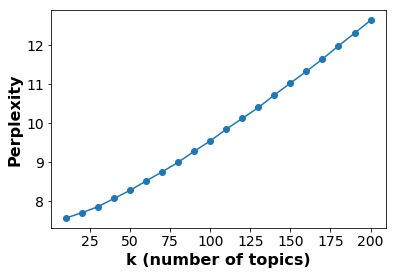

In [18]:
print numTopics, perplexities
plt.plot(numTopics, perplexities,'-o')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('k (number of topics)', fontsize=16, fontweight='bold')
plt.ylabel('Perplexity', fontsize=16, fontweight='bold')

### Comment
Based on the plot above and the quality of one of the topics, k=10 seems to be the best model. LogPerplexity is the lowest for k=10, and looking at the topic words, it seems to be populated with words that are related to machine learning such as training, learning, data, class, classification and algorithm. However, as k increases, the topic words begin to make less and less sense. Even at k=20, there's a combination of dice+chances, cities and votes, I'm not quite sure what this topic is suppsoed to be...
